In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.util.shape import view_as_windows
from sklearn.decomposition import PCA, FastICA
import pandas as pd
# from pandas.tools.plotting import scatter_matrix
from sklearn.manifold import TSNE
import seaborn as sns
import random
import os

%matplotlib inline

### Add paths

In [2]:
path = '../datasets/spoof-data/dataset/Test'
# /media/labiba/New Volume/Experiments/gaze-research/datasets/spoof-data/siw/Test

In [3]:
spoof = glob.glob(f"{path}/spoof/*")
live = glob.glob(f"{path}/live/*")
print(len(spoof), len(live))
spoof = list(np.random.choice(spoof, 100))
live = list(np.random.choice(live, 100))
combined = spoof + live
len(spoof), len(live), len(combined)

33763 26449


(100, 100, 200)

In [4]:
def resize_image(img, save=False):
    img = cv2.resize(img, (224, 224))
    if save:
        cv2.imwrite(im_path, img)
    return img

def resize_all_images(data_folder):
    for im_path in data_folder:
        img = cv2.imread(im_path)
        img = cv2.resize(img, (224, 224))
        cv2.imwrite(im_path, img)

In [5]:
def fetch_images_flattened(data_folder):
    flat_imgs = []
    for im_path in data_folder:
        
        img = cv2.imread(im_path)
        if img is not None:
            flat = img.flatten()
            flat_imgs.append(flat)
        
    return np.array(flat_imgs)

# spoof_array = fetch_images_flattened(spoof)
# live_array = fetch_images_flattened(live)

In [6]:
def flatten_single_patch(patch_grid):
    flattened_patch_grid = []
    for patch_row in patch_grid:
        for patch_col in patch_row:
            flattened_patch_grid.append(patch_col.flatten())
    flattened_patch_grid = np.array(flattened_patch_grid)
    return flattened_patch_grid
def divide_single_img_into_patches(im_path, color_mode, patch_size=(7, 7, 3), step=7):
    if color_mode == 'gray':
        img = cv2.imread(im_path, 0)
    else:
        img = cv2.imread(im_path)
    if img is not None:
        img = resize_image(img)
#     print(img.shape, len(patch_size))
        patch_grid = view_as_windows(img, patch_size, step)
    
#     print(flattened_patch_grid.shape)
        return flatten_single_patch(patch_grid)

def divide_all_into_patches(data_folder, color_mode='rgb'):
    patch_grids = []
    for im_path in data_folder:
        if color_mode == 'gray':
            patch_size = (3, 3)
        else:
            patch_size = (3, 3, 3)
        patch_grids.append(divide_single_img_into_patches(im_path, patch_size=patch_size, color_mode=color_mode))
    print(len(patch_grids))
    patch_grids = list(filter(None.__ne__, patch_grids))
    return np.array(patch_grids)

# patch_grids_spoof = divide_all_into_patches(spoof)
# patch_grids_live = divide_all_into_patches(live)
# patch_grids_combined = np.concatenate((patch_grids_spoof, patch_grids_live), axis=0)
# patch_grids_live.shape, patch_grids_spoof.shape, patch_grids_combined.shape

### pca analaysis of the data

In [7]:
def find_separable_filters(data_folder, do_pca=False, color_mode='gray', get_filter=False):
    
    patch_grids = divide_all_into_patches(data_folder, color_mode)
    if color_mode == 'gray':
        dim = 9
    else:
        dim = 27
    if do_pca:
        pca = PCA(.99)
        pca.fit(patch_grids.reshape(-1, dim))
        patch_grids = pca.transform(patch_grids.reshape(-1, dim))
    print(patch_grids.shape)
    
    fast_ica = FastICA(n_components=None)
    fast_ica.fit(patch_grids.reshape(-1, dim))
    if get_filter:
        return fast_ica.components_
#     print(fast_ica.components_.shape)
#     print(fast_ica.transform(patch_grids.reshape(-1, dim)).shape)
    if do_pca:
        tsne_input = pca.inverse_transform(fast_ica.components_)
    else:
        tsne_input = fast_ica.components_
    tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
    tsne_output = tsne.fit_transform(tsne_input)
    print(f"T-sne shape {tsne_output.shape}")
    return tsne_output

In [8]:
def plot_tsne_figure(tsne_live, tsne_spoof, tsne_combined):
    fig=plt.figure()
    ax=fig.add_axes([0,0,1,1])
    ax.scatter(tsne_live[:,0], tsne_live[:,1], color='r')
    ax.scatter(tsne_spoof[:,0], tsne_spoof[:,1], color='g')
    ax.scatter(tsne_combined[:,0], tsne_combined[:,1], color='b')
    ax.set_xlabel('tsne-1')
    ax.set_ylabel('tsne-2')
    ax.set_title('scatter plot')
    plt.show()

### For gray mode

#### Without pca

In [9]:
# tsne_spoof_gray = find_separable_filters(spoof)
# tsne_live_gray = find_separable_filters(live)
# tsne_combined_gray = find_separable_filters(combined)
# plot_tsne_figure(tsne_live_gray, tsne_spoof_gray, tsne_combined_gray)

#### With pca

In [10]:
# tsne_spoof_gray_pca = find_separable_filters(spoof, do_pca=True)
# tsne_live_gray_pca = find_separable_filters(live, do_pca=True)
# tsne_combined_gray_pca = find_separable_filters(combined, do_pca=True)
# plot_tsne_figure(tsne_live_gray_pca, tsne_spoof_gray_pca, tsne_combined_gray_pca)

### For rgb mode

In [11]:
# tsne_spoof_rgb = find_separable_filters(spoof, color_mode='rgb')
# tsne_live_rgb = find_separable_filters(live, color_mode='rgb')
# tsne_combined_rgb = find_separable_filters(combined, color_mode='rgb')
# plot_tsne_figure(tsne_live_rgb, tsne_spoof_rgb, tsne_combined_rgb)

In [12]:
spoof_components = find_separable_filters(spoof, color_mode='rgb', get_filter=True)
live_components = find_separable_filters(live, color_mode='rgb', get_filter=True)
combined_components = find_separable_filters(combined, color_mode='rgb', get_filter=True)
spoof_components.shape, live_components.shape, combined_components.shape

100
(100, 1024, 27)
100
(100, 1024, 27)
200
(200, 1024, 27)


((27, 27), (27, 27), (27, 27))

In [13]:
def save_ica_filters(components, save_path="filters/33"):
    all_filters = []
    for key in components.keys():
        
        key_path = f"{save_path}/{key}"
        i = 0
        filters = []
        print(components[key].shape)
        for com in components[key]:
#             print(com)
            filter = minmax_scale(com.flatten(), feature_range=(0, 1)).reshape((3, 3, 3))
            filters.append(com)
            cv2.imwrite(f"{key_path}/{i}.jpg", filter*255)
            i += 1
        np.save(f"{save_path}/{key}_filters.npy", np.array(filters))
        all_filters.append(np.array(filters))
    return np.array(all_filters)

In [14]:
from sklearn.preprocessing import minmax_scale
components = {"spoof": spoof_components.reshape((-1, 3, 3, 3)), "live": live_components.reshape((-1, 3, 3, 3)), "combined": combined_components.reshape((-1, 3, 3, 3))}
all_filters = save_ica_filters(components)
all_filters.shape

(27, 3, 3, 3)
(27, 3, 3, 3)
(27, 3, 3, 3)


(3, 27, 3, 3, 3)

### making a convnet

In [1]:
import torch 
import torchvision
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
combined_filters = np.load("filters/33/combined_filters.npy")
spoof_filters = np.load("filters/33/spoof_filters.npy")
live_filters = np.load("filters/33/live_filters.npy")

In [3]:
class TestingModel(torch.nn.Module):
    def __init__(self, filters, set_weights=True):
        super(TestingModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 27, 3)
        if set_weights:
            self.conv1.weight.data = torch.nn.Parameter(torch.tensor(filters).float())
            
        self.conv2 = torch.nn.Conv2d(27, 128, 4, stride=2)
        self.fc = torch.nn.Linear(1548800, 1)
        self.relu = torch.nn.ReLU()
#         self.sigmoid = torch.sigmoid()
    def forward(self, x):
        # self.conv1.weights
#         print(x.shape)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
#         print(x.shape)
        x = x.view(-1, 128*110*110)
#         print(x.shape)
        x = torch.sigmoid(self.fc(x))

        return x

In [4]:
# import glob
# from PIL import Image
# import PIL
# import cv2
# train = "datasets/spoof-data/dataset/Train"
# val = "datasets/spoof-data/dataset/Test"
# train_imgs = glob.glob(f"{train}/**/*.png", recursive=True)
# val_imgs = glob.glob(f"{val}/**/*.png", recursive=True)
# print(len(train_imgs), len(val_imgs))
# import os

# def remove_none_images(img_list):
#     for filename in img_list:
#         try:
# #             im = Image.open(filename)
# #             im.verify() #I perform also verify, don't know if he sees other types o defects
# #             im.close() #reload is necessary in my case
# #             im = Image.open(filename) 
# #             im.transpose(PIL.Image.FLIP_LEFT_RIGHT)
# #             im.close()
#             im = cv2.imread(filename)
#             if im is None:
#                 print(filename)
#                 os.remove(filename)
#         except Exception as e: 
# #             os.remove(filename)
#             print(e)
# #     return img_list
# remove_none_images(train_imgs), remove_none_images(val_imgs)
# train_imgs = glob.glob(f"{train}/**/*.png", recursive=True)
# val_imgs = glob.glob(f"{val}/**/*.png", recursive=True)
# print(len(train_imgs), len(val_imgs))

In [5]:
train = "../datasets/spoof-data/dataset/Train"
val = "../datasets/spoof-data/dataset/Test"
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
def load_dataset(data_path, shuffle, transform):
    dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transform
    )
#     print(dataset[0])
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=32,
        num_workers=16,
        shuffle=shuffle
    )
    return data_loader

train_loader = load_dataset(train, True, transform)
val_loader = load_dataset(val, False, transform)

In [6]:
ica_combined_model = TestingModel(combined_filters).cuda()
random_model = TestingModel(combined_filters, set_weights=False).cuda()
# ica_spoof_model = TestingModel(sp_filters).cuda()
# ica_combined_model = TestingModel(combined_filters).cuda()

In [7]:
bce_loss = torch.nn.BCELoss()
ica_optimizer = torch.optim.Adam(ica_combined_model.parameters())
random_optimizer = torch.optim.Adam(random_model.parameters())

In [8]:
dataiter = iter(train_loader)
im, lab = dataiter.next()

## Spoof: 1, Non-spoof: 0

tensor(0)


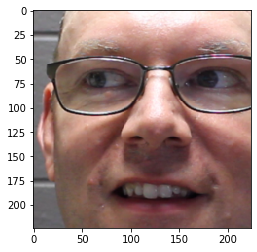

In [9]:
print(lab[3])
plt.imshow(np.transpose(im[3], (1, 2, 0)))
plt.show()

In [10]:
def eval_model(model):
    corrects = 0 
    total = 0
    for idx, (im, label) in enumerate(val_loader):
        im = im.cuda()
        label = label.float().cuda()
        out = model(im)
        preds = (out.data.detach().cpu().numpy() > .5).astype(np.uint8).squeeze(1)
        targets = label.detach().cpu().numpy()
        corrects += np.sum(preds==targets)
        total += 32
    print(corrects, total)
    print(f"validation accuracy {(corrects/total)*100:.2f}%")
    
def train_model(model, optimizer, epochs):
    prev_best = 9999999999
    ep = 0
    total_loss = 0
    for i in range(epochs):
        corrects = 0 
        total = 0
        for idx, (im, label) in enumerate(train_loader):
            im = im.cuda()
            label = label.float().cuda()
            
            optimizer.zero_grad()
            
            out = model(im)
#             print(label.shape, out.shape)
            preds = (out.data.detach().cpu().numpy() > .5).astype(np.uint8).squeeze(1)
            targets = label.detach().cpu().numpy()
            corrects += np.sum(preds==targets)
            total += 32
            out = out.squeeze(1)
            loss = bce_loss(out, label)
            loss.backward()
            optimizer.step()
            total_loss += loss
#             if idx % 20 == 0:
        print("Evaluating the model...")
        model.eval()
        eval_model(model)
        model.train()
        print(f"training accuracy {(corrects/total)*100:.2f}%")
        if prev_best > (total_loss)/(len(train_loader)):
            print(f"Best loss in epoch {i} is {(total_loss)/(len(train_loader))}")
            best_model = model
            prev_best = (total_loss)/(len(train_loader))
            ep = i
    return best_model
train_model(ica_combined_model, ica_optimizer, 1)

Evaluating the model...
51645 60224
validation accuracy 85.75%
training accuracy 88.18%


NameError: name 'prev_loss' is not defined

In [ ]:
torch.save(f'best-model-{ep}.pth', model)

In [48]:
d = np.zeros((128,))

In [49]:
np.sum(d == c)

128

In [50]:
d.shape, c.shape

((128,), (128,))